<a href="https://colab.research.google.com/github/Aaron-Cunningham/Aaron-Cunningham/blob/main/Machine_Learning_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Analytics, Computer Vision & AI - CSC3831
## Coursework, Part 2: Machine Learning

As this coursework is as much about practical skills as it is about reflecting on the procedures and the results, you are expected to explain what you did, your reasoning for process decisions, as well as a thorough analysis of your results.



### 1. Load the MNIST dataset, visualise the first 20 digits, and print their corresponding labels.

In [1]:
# Run this to load the MNIST dataset
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import log_loss

warnings.filterwarnings('ignore', category=ConvergenceWarning)

X, y = fetch_openml(
    'mnist_784', version=1, return_X_y=True, parser='auto', as_frame=False
)

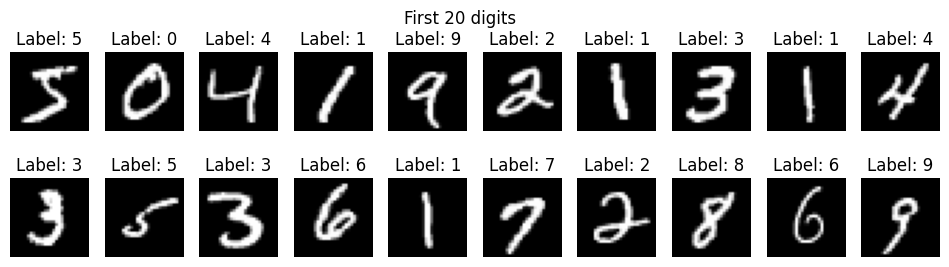

In [2]:
# Code adapted from [https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure]
fig = plt.figure(figsize=(12, 3))

# Visulise the first 20 digits and print their labels
for i in range(20):
  # Set the label
  label = y[i]
  # Set the image
  image = X[i].reshape(28, 28)
  # Add a subplot
  fig.add_subplot(2, 10, i + 1)
  # displays the image in grey scale
  plt.imshow(image, cmap='grey')
  # Sets the title for each plot as the label
  plt.title(f"Label: {label}")
  # Removes the axis that would appear on the plot
  plt.axis('off')
  plt.suptitle("First 20 digits")

# Displays the plot
plt.show()

This displays the first 20 numbers. Above the numbers are the labels related to that number.

### 2. Train a Logistic Regression classifier on this data, and report on your findings.
    
1. Tune your hyperparameters to ensure *sparse* weight vectors and high accuracy.
2. Visualise the classification vector for each class.

#### Setting the baseline

1. The first step I took was splitting the data into training and testing sets using the sklearn `train_test_split()`. I set the `test_size=0.2` this means 80% of the data will be allocated for training and 20% will be allocated for testing. This will help us see how the model performs on unseen data.

- `LogisticRegression()`: This is the model I will be using, I set the `random_state=87` which is used to shuffle the data before splitting it and `max_iter=800`.

3. Next I trained the model using the `fit()` method provided by the sklearn library. This will fit the logistic regression model to the training data and allow it to learn different patterns and relationships within the dataset itself.

4. Next, I used the `predict()` method provided by the sklearn library. The trained model will make predictions on the unseen data (20%) and then compare them to the real values to assess the model performance

5. Finally, I used the `accuracy_score()` and `log_loss()` functions from the sklearn library. `accuracy_score()` will calculate the correctly predicted values and return an accuracy score, whereas the `log_loss()` will tell me the confidence of my model's predictions.


In [3]:
seed = 100
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, )

# initilises logistic regression model.
clf = LogisticRegression(random_state=seed, max_iter=800)

# Fit the model to the training data
clf.fit(X_train, y_train)
# Predicts the labels using test data
y_pred = clf.predict(X_test)
# Predict probabilities for log loss
y_prob = clf.predict_proba(X_test)
# Prints the log loss
print(f"Log Loss: {log_loss(y_test, y_prob):.4f}")
# Prints the accuracy score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")


Log Loss: 0.3313
Accuracy: 91.86%


Great! The model had an **accuracy score** of **91.93%** this means that the model correctly predicted records in the dataset 91.93% of the time and a **log loss** of **0.3297**, which is relatively low it shows me that the model was confident with its predictions. **91.93%** is a respectable score, although, with **Hyper Parameter Tuning** we can try to make out model even better. It was a good idea to set a baseline accuracy score to see what I was initially working with.


#### Tune your hyperparameters to ensure *sparse* weight vectors and high accuracy.

By applying `GridSearchCV`, it allows me to hyper tune my parameters. This will allow me to find the best parameters for my model. The goal is to ensure sparse weight vectors and high accuracy in the logistic regression model. I will do this by:

1. Optimising the regularization strength:
  - First I will tune the regularization parameter `C`. This controls the inverse of the regularization strength [2]. Smaller values specify stronger regularization, which in turn promotes sparsity by reducing the weights of less important features to zero. The range of values I will use are [0.01, 0.1, 1, 10]

2. Penalty:
  - The choice of penalty I will use is `l1`, this is because it is particularly notable for its ability to produce sparse models [3]. This is achieved by forcing many coefficients to zero, therefore, it prioritises smaller absolute values and favouring zeros which encourages sparsity [3]. On the other hand `l2` shrinks the coefficients but does not set them exactly to 0 [4]. Therefore it makes it less suitable for sparse models.

  - As an additional penalty I used `elasticnet`, which only works with the `saga` solver and is very flexible as it combines both `l1` and `l2`regularization together by setting a ratio with the parameter `l1_ratio`. I used `l1_ratio=0.75` this means I will have 75% of l1 regularization and 25% of l2 regularization. This prioritises l1 over l2 to maintain sparsitisy, while also experimenting with the l2 regularization to see if it adds any value to the model.

3. Solver
  - When choosing the solver, I picked both `saga` and `liblinear`. Both `saga` and `libliner` are the only two solvers in Logistic Regression compatible with `l1` regularization, therefore, I tested both of them. It will be interesting to see their results, `saga` typically works better on larger datasets and high-dimensional or sparse data, therefore, it should perform pretty well on the MNIST dataset, on the other hand, liblinear is more efficient on smaller datasets.

3. Max-Iter
  - Initially I have my `max_iter=800` as the maximum number of iterations for the solvers to converge. As part of the hyperparameter tuning, I decided to try higher values within the range of: [300, 500, 1000]. This gives the solvers a better chance to converge to a solution before been terminated.

In [4]:
# logistic regression model initilisation
clf = LogisticRegression(random_state=seed, max_iter=800, tol=0.1)

# sets up the parameter grid for the hyper parameter tuning
param_grid = [
    {'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [300, 500, 1000],},
    {'C': [0.01, 0.1, 1, 10],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'max_iter': [300, 500, 1000],
    'l1_ratio': [0.75, 0.85, 0.95],}
]

# assigns the grid_search parameter with 5-fold cross-validation to find best parameter combination
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
# fits the model
grid_search.fit(X_train, y_train)
tuned_model = grid_search.best_estimator_
# predicts the labels using test data
y_pred = grid_search.predict(X_test)
# probabilities for log loss calculation
y_prob = grid_search.predict_proba(X_test)
# Calculates an accuracy score based off the predictions
acc = accuracy_score(y_test, y_pred)
# Calculates the log loss
loss = log_loss(y_test, y_prob)


# Prints the best parameter combinations found in grid search
print(f'Best Parameters: {grid_search.best_params_}')
# Prints the best cross-validation score
print(f'Best CV Score: {grid_search.best_score_:.2%}')
# Prints the accuracy of the model
print(f'Test Accuracy: {acc:.2%}')
# Prints the log loss of the model
print(f"Log Loss: {loss:.4f}")


Best Parameters: {'C': 0.1, 'max_iter': 300, 'penalty': 'l1', 'solver': 'saga'}
Best CV Score: 91.93%
Test Accuracy: 92.36%
Log Loss: 0.2787


Great we have improved our accuracy score by achieving **92.36%** test accuracy. That is a 0.43% increase over the original model before hyperparameter tuning. Additioanlly, a log loss of **0.2787**, which is 0.051 lower before the hyperparameter tuning shows me that the model is even more confident with its predictions.

The best parameters turned out to be:
- `C = 0.1`
- `penalty = l1`
- `solver = saga`
- `max_ter = 300`.

These results were expected for the MNIST dataset, `penalty = l1` and `C = 0.1` show a balanced regularization strength that keeps some sparsity without swaying too much accuracy. The `solver = saga` also makes sense as it is designed to work well with large and multi-nominal datasets such as MNIST. Finally, `max_iter=300` gave the model enough iterations to converge properly.

I decided to use `cv=5` for cross-validation, which splits the data into 5 folds, This ensures a more reliable performance estimate by testing the model across subsets of the data. This allowed better fine-tuning of hyperparameters and achieving a stronger accuracy. The best **CV Score** during tuning was **91.93%** and the **Test Accuracy** of **92.36%**, this shows that there is no overfitting or underfitting as the model performs consistently on the CV and test data.

#### Visualise the classification vector for each class

When visualising the classification vectors of the trained logistic regression model, we can look at the coefficients of each for each digit (0-9). By looking at the coefficient of each vector we can see how much each pixel influences the model's decision to classify an image as that specific digit.

I adapted the code from earlier when visualising the first 20 digits, but instead this time I used the tuned_model to access the coefficient vectors for each digit class using `coef_`. I labelled each class above each image for clarity to represent each number (class 0 represents the digit 0 etc.). I matched the size of the MNIST images by setting a grid of 28x28 which will display 784 pixels for each grid. Further, I'm using `c_map=plt.cm.RdBu` this will highlight the influence of each pixel, blue colours will show positive coefficients which support prediction for that class and red pixels will show negative coefficients which don't support the prediction for that class.

Let's take a look at the plot below.


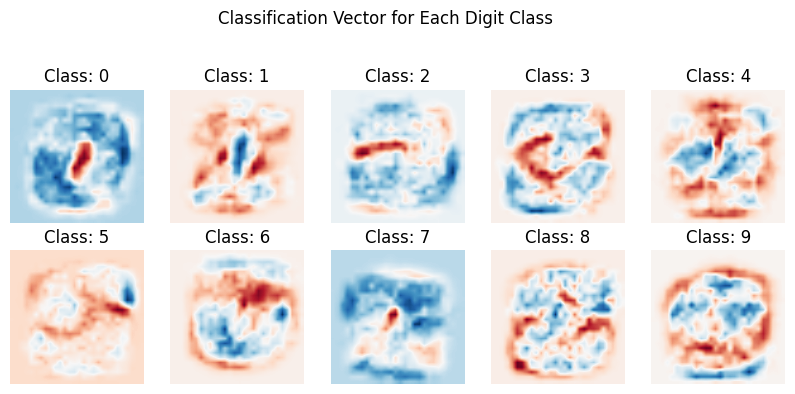

In [5]:
# Code adapted from [https://atmamani.github.io/projects/ml/mnist-digits-classification-using-logistic-regression-scikit-learn/]
fig = plt.figure(figsize=(10, 8))
coef = tuned_model.coef_
for i in range(10):
  # Set the label
  label = i
  fig.add_subplot(4, 5, i + 1)
  plt.imshow(coef[i].reshape(28,28), cmap=plt.cm.RdBu,
                    interpolation='bilinear')
  # Sets the title for each plot as the label
  plt.title(f"Class: {label}")
  # Removes the axis that would appear on the plot
  plt.axis('off')


plt.suptitle('Classification Vector for Each Digit Class')
# Displays the plot
plt.show()

The heatmaps visualised here provide insight into how the logistic regression model distinguishes between each digit. The tuned model has learned different patterns related to each digit. Below I will outline some interesting findings about this plot.

- A good example of this would be the digit 0 (class: 0) where the model has a high positive coefficient on the outer ring, representing the circular shape of '0', thus, helping the model identify the unique shape of this digit. The negative coefficients in the centre don't play a huge role in determining this class, this further strengthens the model's focus on defining class 0 by its circular shape in the outer ring.

- The digit 1 (class: 1) shows a positive coefficient in the centre that is vertical much like the real digit '1'.

- For digit 2 (class: 2) the positive weights are more concentrated around the top curve and middle, this captures its horizontal line that goes through the middle and then the loop near the bottom.

- For the digit 3 (class: 3) it captures its double curve well showing a positive coefficient top left and to the centre then bottom left and to the centre, much like 0 it is very interpretable which digit it is trying to represent.

- When looking at the digits 6 (class: 6) and 9 (class:9) they are almost the inverse of each other. 6 has a positive coefficient around the top which captures the top curve whereas 9 has a positive coefficient around the bottom capturing the bottom curve. Since the model places a positive emphasis inverse to each other at the top for 6 and bottom for 9, it allows it to differentiate between these two visually similar numbers.

- For digit 7 (class: 7) it shows a positive coefficient at the top representing its straight horizontal line and then the vertical line which is also apparent in digit 7.





#### Confusion Matrix

Additionally, we can check how well our model predicts digits using a confusion matrix. The X axis is the predicted label, it is then compared to the true label on the Y axis.

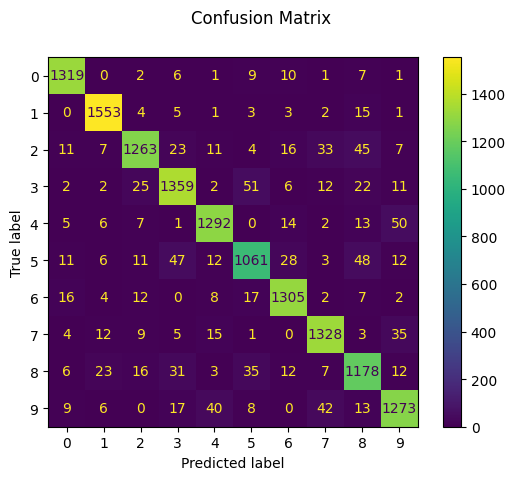

In [6]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

As we can see the hypertuned model predicts digits very well, with only a small amount of predicted labels predicting wrong. This confirms that our model is predicting the data well.

### 3. Use PCA to reduce the dimensionality of your training data.
    
1. Determine the number of components necessary to explain 80\% of the variance
2. Plot the explained variance by number of components.
3. Visualise the 20 principal components' loadings
4. Plot the two principal components for your data using a scatterplot, colouring by class. What can you say about this plot?
5. Visualise the first 20 digits, *generated from their lower-dimensional representation*.

#### Determine the number of components necessary to explain 80% of the variance

Before we continue I will check the current number of features in the dataset before performing PCA

In [7]:
print("Number of features:", X_train.shape[1])

Number of features: 784


As we can see there are 784 features present in the dataset, this is a large amount and will benefit from dimensionality reduction using PCA.

In order to reduce the dimensionality of the MNST dataset, I will use the **First Principal Component** (PCA). PCA is a statistical technique used to simplify data by reducing its dimensions while preserving as much variability as possible [5].

To determine the number of components necessary to explain 80% of the variance, I will initilise PCA using `PCA()` provided by `sklearn` and then fit it to the trained data from the previous step. Finally, I will calculate the cumulative explained variance ratio for all the components in the dataset, which allows me to pinpoint the minimum number of components needed to explain 80% of the variance.

In [8]:
import numpy as np

# Initilises PCA
pca = PCA().fit(X_train)

# Calculates the cumulative explained variance ratio. Code adapted from [https://www.baeldung.com/cs/pca]
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
number_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of components needed to explain 80% of the variance: {number_components_80}")

Number of components needed to explain 80% of the variance: 43


After applying PCA to reduce the dimensionality of the dataset we can see that 43 components are needed to explain 80% of the variance. This has reduced the dimensionality of the dataset by a significant amount (originally 784) which we calculated earlier, while also maintaining 80% of the explained variance.

#### Plot the explained variance by number of components

To visualise the cumulative explained varience, I will plot the explained variance against the number of principal components.


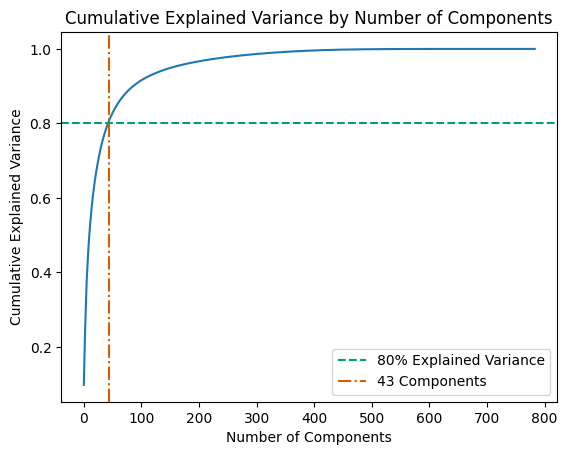

In [9]:
# Code adapted from [https://colab.research.google.com/drive/1rwHmzIA18PTudDy_HzIDQ0HKbkmk_wbZ?usp=sharing#scrollTo=NKJCiP9Cq3ja][13]
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');
plt.axhline(y=0.8, color='#009E73', linestyle='--', label="80% Explained Variance")
plt.axvline(x=number_components_80, color='#D55E00', linestyle='-.', label=f"{number_components_80} Components")
plt.legend()
plt.title('Cumulative Explained Variance by Number of Components')
plt.show()

The horizontal line represents 80% cumulative explained variance and the verticle line represents the number of components needed to reach this threshold (43). In other words, by using the first 43 principal components, we can retain 80% of the total variance in the dataset.



#### Visualise the 20 principal components' loadings

I will now display the first 20 principal components loadings. I will adapt the code I used originally for the first 20 digits.

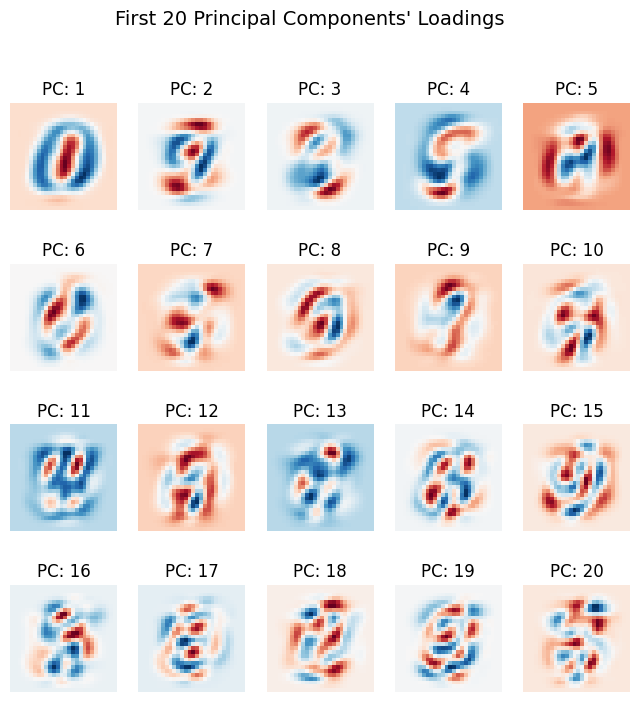

In [10]:
fig = plt.figure(figsize=(8, 8))

# Visulise the first 20 digits and print their labels
for i in range(20):
  # Set the label
  label = i + 1
  # Set the image
  component_image = pca.components_[i].reshape(28, 28)
  # Add a subplot
  fig.add_subplot(4, 5, i + 1)
  plt.imshow(component_image, cmap=plt.cm.RdBu)
  # Sets the title for each plot as the label
  plt.title(f"PC: {label}")
  # Removes the axis that would appear on the plot
  plt.axis('off')
plt.suptitle("First 20 Principal Components' Loadings", fontsize=14)

# Displays the plot
plt.show()


This gives us some interesting results and shows how PCA captures these images. Starting from the top left, the first few principal components show some circular patterns such as `PC: 1` and `PC: 2`. These are common among many digits such as 0, 6, 9, and 8. Moving along we can examine `PC: 3`, this introduces some new patterns such as curved lines which could represent digits such as 8, 3, and in some cases 2. The early principal components capture basic shapes and patterns to a point where I can interpret some shapes and patterns.

On the other hand, as we move to the later principal components, they appear to become less interpretable and complex. For example, comparing `PC: 1` & `PC: 3` where you can clearly see some shapes and patterns to `PC: 19` & `PC: 20` which appear very noisy and capture fewer shapes and patterns. This is to be expected as each additional principal component explains less and less variance in the data, thus explaining why the later principal components are less interpretable. This is supported by the Wikipedia article Principal Component Analysis "PCA thus can have the effect of concentrating much of the signal into the first few principal components, which can usefully be captured by dimensionality reduction; while the later principal components may be dominated by noise, and so disposed of without great loss" [6].



#### Plot the two principal components for your data using a scatterplot, colouring by class. What can you say about this plot?

First I will apply PCA and reduce the data down to its two principal components using the `PCA()` method. I will then calculate the **Explained Variance Ratio** as it will tell me about how much total variance is maintained after reducing the dataset to the first two principal components.

In [11]:

# Applies PCA to reduce to two principal components
pca_two = PCA(n_components=2)
pca_two.fit(X_train)
X_pca_two = pca_two.transform(X_train)
explained_variance_ratio = pca_two.explained_variance_ratio_
print(f"{explained_variance_ratio.sum():.2%}")


16.92%


Only 16.92% of the total variance is maintained after reducing the dataset to the first 2 principal components. This means that 83.08% was lost in the dimensionality reduction. Later we will see what effect this has on the MNIST images when reconstructing the data back to its original form.

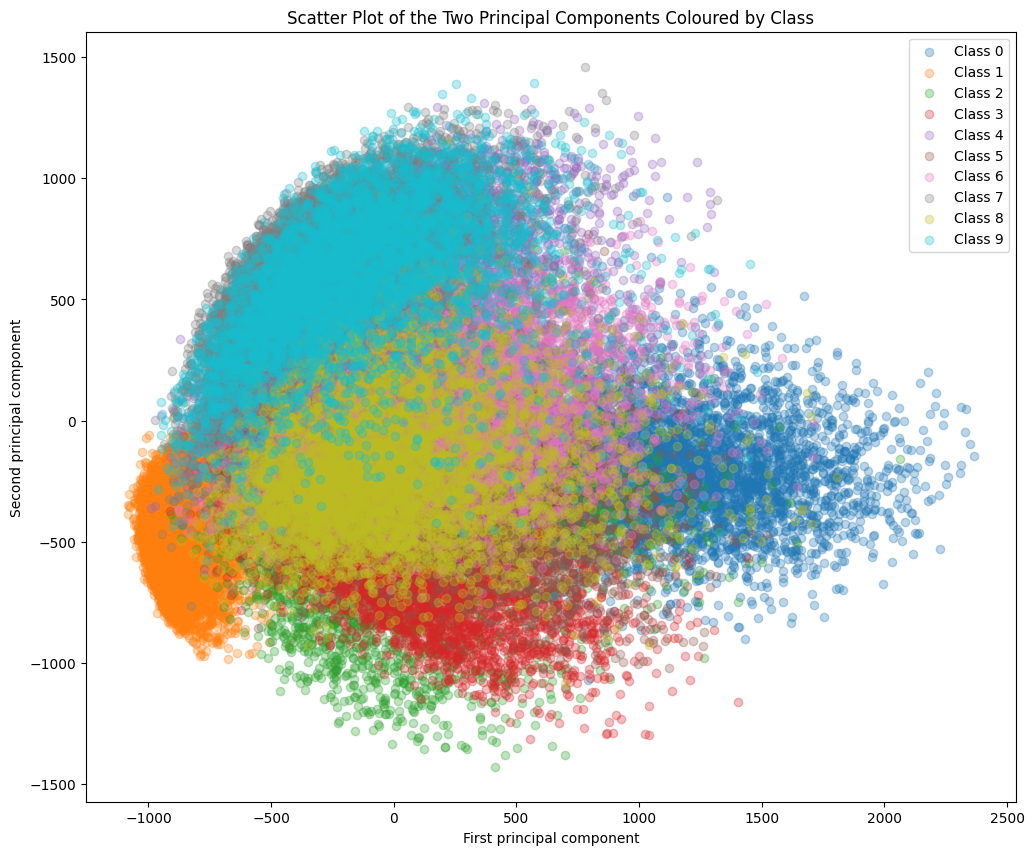

In [12]:
# Plot Code adapted from [https://colab.research.google.com/drive/1rwHmzIA18PTudDy_HzIDQ0HKbkmk_wbZ?usp=sharing#scrollTo=283ec4d4][21]

# Sets the colours as tab10 for the categories
colors = plt.cm.tab10(np.linspace(0, 1, len(set(np.unique(y_train.astype(int))))))
labels = y_train.astype(int)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
for k, col in enumerate(colors):
    class_mask = (labels == k)
    ax.scatter(X_pca_two[class_mask, 0], X_pca_two[class_mask, 1], color=col, alpha=0.3, label=f"Class {k}")
# adds x, y, title, and legend
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_title("Scatter Plot of the Two Principal Components Coloured by Class")
ax.legend()

# displays the plot
plt.show()

Above is a scatter plot with Principal Component 1 on the **x** axis and Principal Component 2 on the **y** axis. The different classes are colour-coded using distinct colours for better visualisation.

I will now go through my observations of the scatter plot.

- **Classes Overlapping:** The first observation I can make about this data is how much certain classes overlap. This indicates that the classes are not easily separable, and 2 Principal components alone wouldn't be enough to distinguish between the different classes. For example, **Class 5** (Grey) and **Class 9** (Light Blue) are heavily overlapping, this indicates that the 2 Principal Components won't easily be able to distinguish between these two classes and therefore struggle with accuracy.

- **Clustering:** On the other hand, **Class 1** (Orange) on the left side of the chart is less affected by overlapping and is clustered together. Therefore, the 2 Principal Components may be able to distinguish this class more successfully than other classes.

- **Spread:** Lastly, the data points are widely distributed across the scatter plot. They seem to be more widely spread across the **x** axis as it ranges from approximately **-1000 to 2500** whereas the **y** axis which has a range of **-1500 to 1500**. This means the **x** axis captures more variance than the **y** axis. This makes sense, as the **x** axis is the First Principal Component which is expected to explain the maximum variance in the data, followed by the Second Principal Component.

#### Visualise the first 20 digits, generated from their lower-dimensional representation.

In order to visualise the first 20 digits generated from their lower-dimensional representation, I will first need to reconstruct the data back to its original form after it was reduced to the first two principal components.  This is done using the `inverse_transform` method. This works by bringing the data back to its original dimensionality (784). It will approximate each digit image but only with the information it retained from the first two principal components which only had a total variance retention of **16.92%**.

This will then be plotted in grey scale, let's visualise the results!

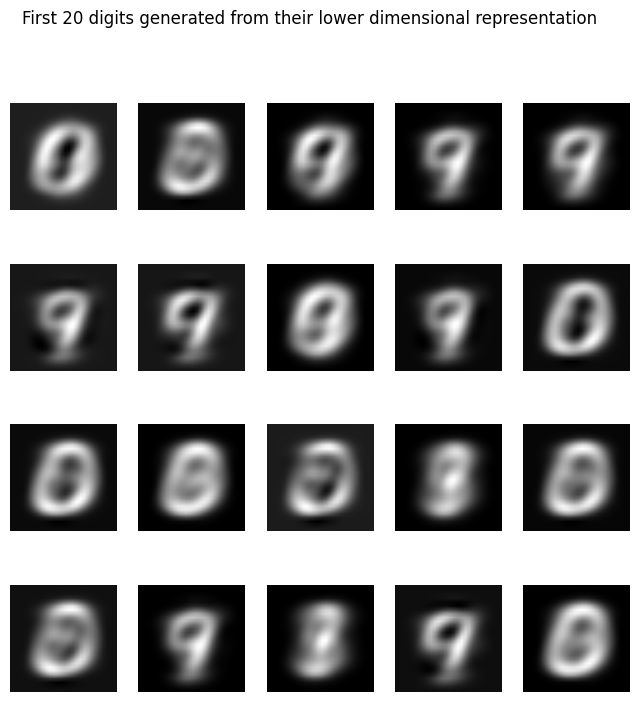

In [13]:
# Plot adapted from [https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure]

# Reconstructing the data back to original form
X_pca_two_reconstructed = pca_two.inverse_transform(X_pca_two)

fig = plt.figure(figsize=(8, 8))


for i in range(20):
  # Set the image
  image = X_pca_two_reconstructed[i].reshape(28, 28)
  # Add a subplot
  fig.add_subplot(4, 5, i + 1)
  # displays the image in grey scale
  plt.imshow(image, cmap='grey', interpolation='bilinear')
  # Removes the axis that would appear on the plot
  plt.axis('off')

plt.suptitle("First 20 digits generated from their lower dimensional representation")
# Displays the plot
plt.show()


From looking at the produced plot, the reconstruction of the data frame from lower-dimensional representation has done a good job of preserving some shapes and patterns for the original digits. For example, digits such as 0, 8, and 9 are easily identifiable. With 0 you can clearly see the outline of the singular circle, with 8 it's a similar story where you can see the outline of the 2 circles, and 9 where you can identify vertical lines and loop near the top.

Although not perfect, the digits appear to have distortions associated with their reconstruction. This is to be expected though as the data frame was reconstructed using only 16.92% of the explained variance. This demonstrates the limitations that come with reconstructing data from low variance thresholds where meaningful patterns and shapes are lost.

### 4. Generate a noisy copy of your data by adding random normal noise to the digits **with a scale that doesn't completely destroy the signal**. This is, the resulting images noise should be apparent, but the numbers should still be understandable.
    
1. Visualise the first 20 digits from the noisy dataset.
2. Filter the noise by fitting a PCA explaining **a sufficient proportion** of the variance, and then transforming the noisy dataset. Figuring out this proportion is part of the challenge.
3. Visualise the first 20 digits of the de-noised dataset.

#### 1) Visualise the first 20 digits from the noisy dataset.

In this section, I will add 'Gaussian  nose' with a factor of `0.25`. I tested a couple of differnt values such as **0.25**, **0.30**, **0.80**, and **0.50** but decided to go with **0.25** as I thought visually it looked like a large amount of noise without completely destroying the signal.

In order to create my noise I conducted a few different steps:

- Scaling the data: This sets all the values in the data between 0 and 1. This was done to simplify calculations for generating my Gaussian noise.

- Setting a noise factor: This determines the intensity of the noise in my data. As summed up by Harvey Slash, the noise is a factor and will be multiplied against the standard normal distribution (In this case Gaussian Distribution) [7]. `0.25` was a good balance between preserving too much of the image and making the images too difficult to interpret.

- Generating noise (Gaussian): This is generating a random array with Gaussian distribution. `loc=0.0` is the mean, which marks the centre of the distribution, `scale=1` is the standard deviation–how much the noise values spread out from the mean, `size=X_copy.shape` generates the noise with the same shape as the image.

- Clipping the data: After adding noise to the images, some of the pixel values might fall outside the range [0,1] (Set earlier when we scaled the data). Therefore, any pixel values < 0 will be set to 0 and any pixel values > 1 will be set to 1.


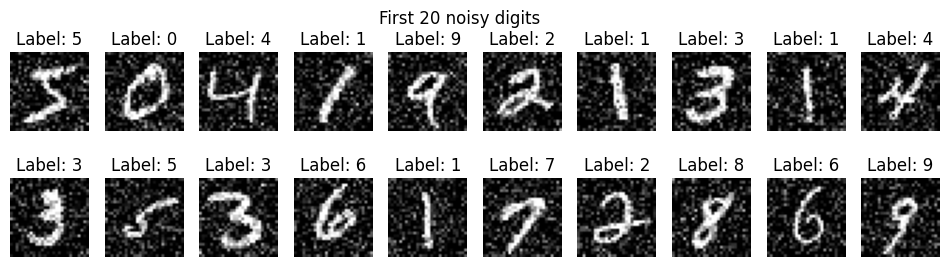

In [14]:
# Make a copy of the original data
X_copy = X.copy()

# Code adapted from [https://stackoverflow.com/questions/54571938/how-to-add-50-random-normal-noise-to-mnist-dataset-in-python]
X_copy = X_copy.astype(np.float32)
# Scale the dataset
X_copy /= 255.0
# Generate noisy data
noise_factor = 0.25
X_noisy = X_copy + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_copy.shape)
X_noisy = np.clip(X_noisy, 0., 1.)

fig = plt.figure(figsize=(12, 3))
# Visulise the first 20 digits and print their labels
for i in range(20):
  label = y[i]
  # Set the image
  image = X_noisy[i].reshape(28, 28)
  # Add a subplot
  fig.add_subplot(2, 10, i + 1)
  # displays the image in grey scale
  plt.imshow(image, cmap='grey')
  plt.title(f"Label: {label}")
  # Removes the axis that would appear on the plot
  plt.axis('off')
plt.suptitle("First 20 noisy digits")

# Displays the plot
plt.show()

The images are now displaying with the **Gaussian noise**. The Gaussian noise adds random noise (dots) on top of the base images that make it noisy.

These are the first 20 digits, accompanied by their corresponding labels. The digits still appear readable and the signal wasn't completely destroyed in the process. Let now try to remove this noise.

#### 2) Filter the noise by fitting a PCA explaining a sufficient proportion of the variance, and then transforming the noisy dataset. Figuring out this proportion is part of the challenge. And then visualise the first 20 digits of the de-noised dataset

Number of features after retaining to explain 75.00% of the variance: 233


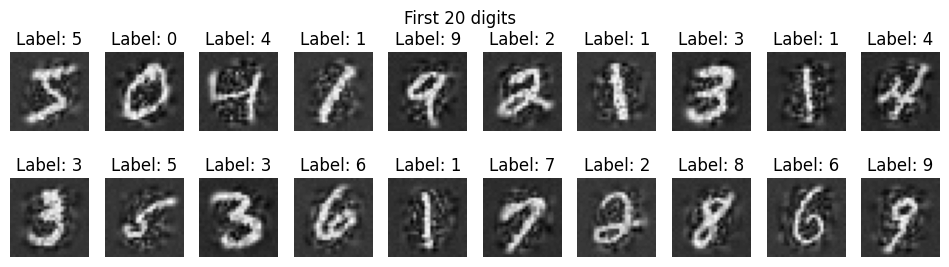

Number of features: 784


In [15]:
# Fit PCA to the noisy dataset
retained_variance = 0.75
pca_noisy = PCA(n_components=retained_variance)
pca_noisy.fit(X_noisy)

# Print the number of components selected
print(f"Number of features after retaining to explain {retained_variance:.2%} of the variance:", pca_noisy.n_components_)

# Transforms the noisy dataset to lower-dimensional
X_noisy_lower = pca_noisy.transform(X_noisy)
# reconstructs it back again
X_noisy_reconstructd = pca_noisy.inverse_transform(X_noisy_lower)

# Visulise the first 20 digits and print their labels
fig = plt.figure(figsize=(12, 3))
for i in range(20):
  # Set the label
  label = y[i]
  # Set the image
  image = X_noisy_reconstructd[i].reshape(28, 28)
  # Add a subplot
  fig.add_subplot(2, 10, i + 1)
  # displays the image in grey scale
  plt.imshow(image, cmap='grey')
  # Sets the title for each plot as the label
  plt.title(f"Label: {label}")
  # Removes the axis that would appear on the plot
  plt.axis('off')
  plt.suptitle("First 20 digits")

# Displays the plot
plt.show()

# Print the number of components selected
print("Number of features:", X_noisy_reconstructd.shape[1])


Great, we have managed to remove a good amount of the noise that was originally there. The digits are still very interpretable. For example, I can make out the first 5 numbers on the top row to be 5, 0, 4, 1, and 9.

I used PCA to reduce the dimensionality of the dataset, managing to keep **75%** of the variance. This gave me a good balance between removing the noise that was present in the images, while also maintaining the important shapes and patterns in the images. The dataset was Initially reduced to 233 features and then reconstructed again using `inverse_transform()` method which uses the 233 features to approximate the original data before it was reduced.

In conclusion, I was happy with this result. PCA is a good tool to use in cases where noise needs to be removed from data. As stated by Jim Frost, "PCA can remove noise or other nuisance variation by identifying the principal components that explain the most variation" [8], meaning PCA focuses on meaningful patterns and shapes and ignores the rest.


# References

[1] GeeksforGeeks, “Logistic Regression and the Feature Scaling Ensemble,” GeeksforGeeks, Apr. 22, 2024. https://www.geeksforgeeks.org/logistic-regression-and-the-feature-scaling-ensemble/ (accessed Nov. 10, 2024).

[2] scikit-learn, “LogisticRegression,” scikit-learn, 2024. https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html (accessed Nov. 10, 2024).

[3] Shubham Sangole, “The Minimalist Approach: Understanding Why L1 Regularization Creates Sparse Models,” Medium, May 28, 2024. https://medium.com/@sangoleshubham20/the-minimalist-approach-understanding-why-l1-regularization-creates-sparse-models-8b911f5466af (accessed Nov. 11, 2024).

[4] “Understanding Regularization: L1 vs. L2 Methods Compared,” dataheadhunters.com, Jan. 24, 2024. https://dataheadhunters.com/academy/understanding-regularization-l1-vs-l2-methods-compared/ (accessed Nov. 12, 2024).

[5] “Principal component analysis (PCA) - (Big Data Analytics and Visualization) - Vocab, Definition, Explanations | Fiveable,” Fiveable.me, 2024. https://library.fiveable.me/key-terms/big-data-analytics-and-visualization/principal-component-analysis-pca (accessed Nov. 13, 2024).

[6] Wikipedia Contributors, “Principal component analysis,” Wikipedia, Mar. 26, 2019. https://en.wikipedia.org/wiki/Principal_component_analysis (accessed Nov. 14, 2024).

[7] H. Slash, “how to add 50% random normal noise to Mnist dataset in python,” Stack Overflow, Feb. 07, 2019. https://stackoverflow.com/questions/54571938/how-to-add-50-random-normal-noise-to-mnist-dataset-in-python (accessed Nov. 14, 2024).

[8] J. Frost, “Principal Component Analysis Guide & Example,” Statistics By Jim, Jan. 29, 2023. https://statisticsbyjim.com/basics/principal-component-analysis/ (accessed Nov. 15, 2024).